# Домашнее задание № 6

## по дисциплине: Машинное обучение в бизнесе

### выполнил: Евгений Кириллов

### Домашнее задание

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
6. применить random negative sampling для построения классификатора в новых условиях
7. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
8. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

## Задания 1-3

## data set information

data set taken: https://archive.ics.uci.edu/ml/datasets/Adult

Extraction was done by Barry Becker from the 1994 Census database. 

Prediction task is to determine whether a person makes over 50K a year.

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import StandardScaler

# from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

import itertools
import math

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("adult_data.csv", 
                 names=['age', 'workclass', 'census-bureau-weight', 'education', 'education-num',
                        'marital-status', 'occupation', 'relationship', 'race', 'sex', 
                        'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'target']) 

In [3]:
df.head(2)

,age,workclass,census-bureau-weight,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


In [4]:
df.isna().sum().sum()

0

In [5]:
df.shape

(32561, 15)

In [6]:
df.dtypes

age                      int64
workclass               object
census-bureau-weight     int64
education               object
education-num            int64
marital-status          object
occupation              object
relationship            object
race                    object
sex                     object
capital-gain             int64
capital-loss             int64
hours-per-week           int64
native-country          object
target                  object
dtype: object

In [7]:
df_num_features = df.select_dtypes(include=['int64'])

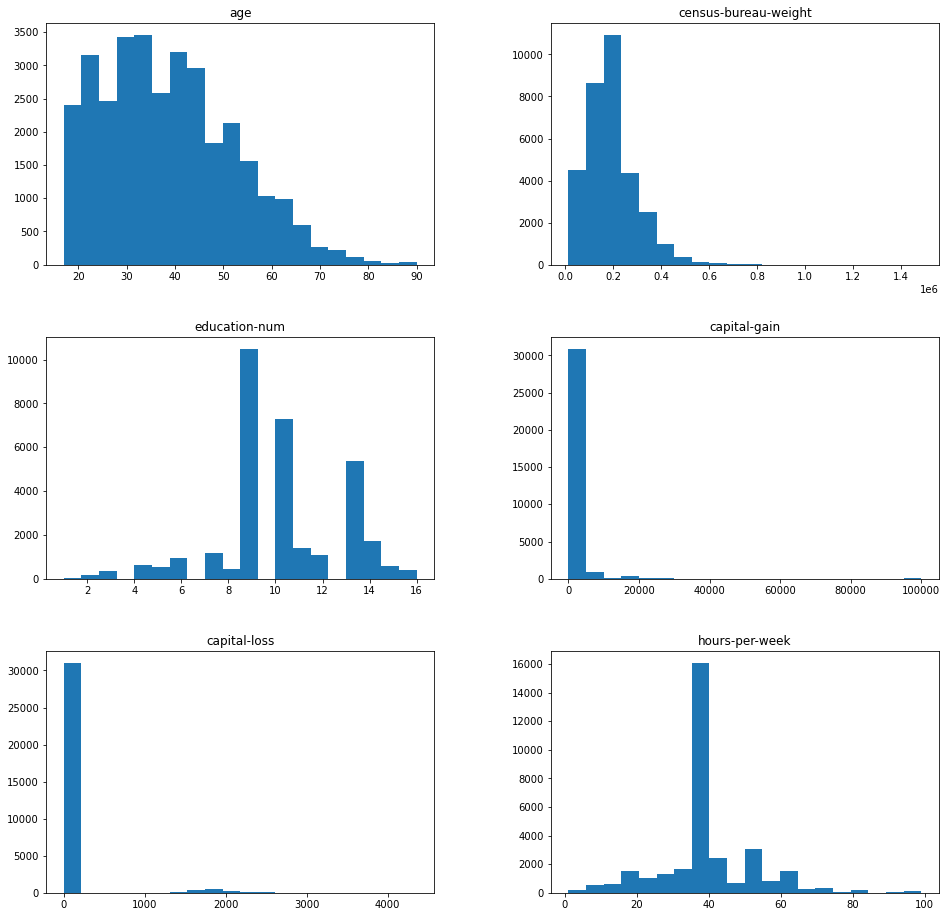

In [8]:
df_num_features.hist(figsize=(16, 16), bins=20, grid=False);

In [9]:
df['target'] = df['target'].map({
    ' <=50K': 0,
    ' >50K': 1
})

In [10]:
df['target'].value_counts()

0    24720
1     7841
Name: target, dtype: int64

### train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df, 
                                                    df['target'], 
                                                    test_size=0.3,
                                                    random_state=2022)

### undersampling X_train

In [12]:
# y_train.value_counts()

In [13]:
# objects_1 = y_train[y_train == 1]
# objects_1.size

In [14]:
# objects_0 = y_train[y_train == 0].sample(objects_1.size)
# objects_0.size

In [15]:
# y_train = pd.concat([objects_1, objects_0])
# X_train = X_train.loc[y_train.index]

### pipeline

In [16]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

    
class FeatureLogarithm(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.key] = X[self.key].apply(lambda x: math.log(x) if x != 0 else 0)
        return X[[self.key]]
    
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [17]:
df.columns

Index(['age', 'workclass', 'census-bureau-weight', 'education',
       'education-num', 'marital-status', 'occupation', 'relationship', 'race',
       'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
       'native-country', 'target'],
      dtype='object')

In [18]:
categorical_columns = [
    'workclass', 
    'education', 
    'marital-status', 
    'occupation', 
    'relationship', 
    'race', 
    'sex', 
#     'native-country'
]

continuous_columns = [
    'age', 
    'census-bureau-weight', 
    'education-num',
    'capital-gain', 
    'capital-loss', 
    'hours-per-week'
]

columns_to_log = [
#     'hours-per-week'
]

In [19]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))

    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ]) 
    final_transformers.append((cont_col, cont_transformer))

    
for log_col in columns_to_log:
    log_transformer = Pipeline([
                ('selector', FeatureLogarithm(key=log_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((log_col, log_transformer))

In [20]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

### model

In [21]:
pipeline_with_classifier = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(random_state=2022)),
])

# GradientBoostingClassifier
# LogisticRegression

In [22]:
pipeline_with_classifier.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('workclass',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='workclass')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='workclass'))])),
                                                ('education',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='education')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='education'))])),
                                                ('marital-status',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSele...
                                                                  NumberSelector(key='capital-gain')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('capital-loss',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='capital-loss')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('hours-per-week',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='hours-per-week')),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('classifier', GradientBoostingClassifier(random_state=2022))])

In [23]:
y_score = pipeline_with_classifier.predict_proba(X_train)[:, 1]

In [24]:
y = y_train
b=1
precision, recall, thresholds = precision_recall_curve(y.values, y_score)
precision += 0.0001
recall += 0.0001
fscore = (1+b**2) * (precision * recall) / (b**2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.354695, F-Score=0.737, Precision=0.710, Recall=0.767


### metrics

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
y_score = pipeline_with_classifier.predict_proba(X_test)[:, 1]

Confusion matrix, without normalization
[[6628  808]
 [ 619 1714]]


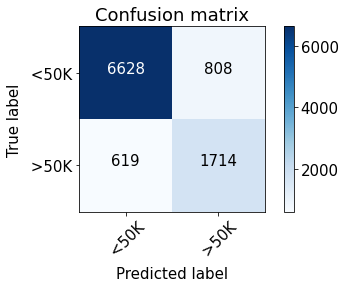

In [27]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=[' <50K', ' >50K'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

In [28]:
print(classification_report(y_test, y_score > thresholds[ix]))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      7436
           1       0.68      0.73      0.71      2333

    accuracy                           0.85      9769
   macro avg       0.80      0.81      0.80      9769
weighted avg       0.86      0.85      0.86      9769



## Задания 4-6

In [29]:
P = 0.5
P_sample_size = int(df['target'].value_counts()[1] * P)
P_sample_size

3920

In [30]:
df['PU'] = 0
positive_indexes = df.loc[df['target'] == 1].sample(P_sample_size).index
df.loc[positive_indexes, 'PU'] = 1
df['PU'].value_counts()

0    28641
1     3920
Name: PU, dtype: int64

In [31]:
pipeline_with_classifier.fit(df, df['PU'])
y_score = pipeline_with_classifier.predict_proba(df)[:, 1]

### threshold finding

In [32]:
y = df['PU']  # df['PU'] to find the best threshold!!!

In [33]:
b=1
precision, recall, thresholds = precision_recall_curve(y.values, y_score)
precision += 0.0001
recall += 0.0001
fscore = (1+b**2) * (precision * recall) / (b**2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
# print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
#                                                                         fscore[ix],
#                                                                         precision[ix],
#                                                                         recall[ix]))

### metrics

In [34]:
y = df['target']  # df['target'] to calculate metrics

Confusion matrix, without normalization
[[23067  1653]
 [ 2759  5082]]


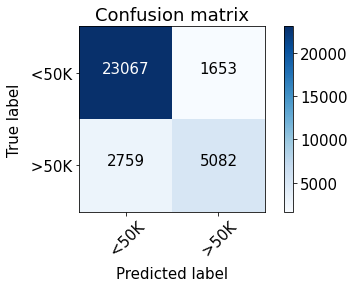

In [35]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y, y_score>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=[' <50K', ' >50K'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

In [36]:
print(classification_report(y, y_score>thresholds[ix]))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     24720
           1       0.75      0.65      0.70      7841

    accuracy                           0.86     32561
   macro avg       0.82      0.79      0.81     32561
weighted avg       0.86      0.86      0.86     32561



## качество модели поиска look-alike (при P = 0.5) примерно одинаково с обычным классификатором 

## Задание 7

In [37]:
def finding_dependencies_between_P_and_f1_score(P):
    # creation of P/U binary feature
    P_sample_size = int(df['target'].value_counts()[1] * P)
    df['PU'] = 0
    positive_indexes = df.loc[df['target'] == 1].sample(P_sample_size).index
    df.loc[positive_indexes, 'PU'] = 1
    
    # fitting pipeline
    pipeline_with_classifier.fit(df, df['PU'])
    
    # score calculation
    y_score = pipeline_with_classifier.predict_proba(df)[:, 1]
    
    # threshold finding
    b=1
    precision, recall, thresholds = precision_recall_curve(df['PU'].values, y_score)
    precision += 0.0001
    recall += 0.0001
    fscore = (1+b**2) * (precision * recall) / (b**2 * precision + recall)
    ix = np.argmax(fscore)
    
    # returning f1_score
    return f1_score(df['target'], y_score>thresholds[ix])

In [38]:
P = np.linspace(0.1, 0.9, 9)
F1 = [finding_dependencies_between_P_and_f1_score(_) for _ in P]

In [39]:
pd.DataFrame({
    'P': P,
    'F1': F1
})

,P,F1
0,0.1,0.128886
1,0.2,0.479587
2,0.3,0.570547
3,0.4,0.681802
4,0.5,0.693307
5,0.6,0.713713
6,0.7,0.705587
7,0.8,0.721245
8,0.9,0.725981


## качество модели при увеличении P улучшается